In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


Import the needed packages for this model. This model uses Keras Tensor Flow.

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
import cv2  
from keras.optimizers import Adam, SGD #Import Optimization Functions
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In this step the data (that is already pre-imported for the Kaggle Competition) is read using the read_csv function. The file path is found running the first Kaggle pre-written chunk of code. The results of the read csv file are stored in an dataframe called "train_df."

Before the data is ready to feed through a CNN, we need to pretreat the data. The first step is to seperate the pixel data from the labels in the training data so the model has correct labeled data to train on. The iloc funtion is used to seperate the pixel data stored in an object called "X" and the label data (found in the first column) stored in an object called "y". 


Finally, to find the shape of the csv file we call the shape function. We can see there are 60,000 pictures stored as 784 pixels strings. 28x28 = 784 so we know we have the correct dimensions.

In [3]:
# Load and preprocess the data
train_df = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')

# Separate features and labels
X = train_df.iloc[:, 1:].values.astype(np.float32)  # pixel data
y = train_df.iloc[:, 0].values  # labels

X.shape


(60000, 784)

The csv file is a list of grayscale pixel values. We know that the true natrue of these pictures are in a 28x28 grid. In order to use a Convolutional Neural Network (CNN) we must reshape the data to have the 28x28x1 shape. The 1 is the single grayscale pixel value. 

Most pre-trained models require the use of RGB color scale and would therefore require 3 as the pixel value shape arguement. Pre-trained models MobileNet2 and VGG16 were explored for this competition, however it was determined through experimentation and many trials that an original, simplified architecture was better for this particular use case/competition. More in depth on this below... 

In [4]:
# Assuming X has the shape (60000, 784) where 784 = 28x28 
#Reshape the data to seperate the individual pictures in the stored in the csv file
X_reshaped = X.reshape(-1, 28, 28, 1)  # Reshape to (num_samples, 28, 28, 1)

The below chunk calls the ImageGenerator. This is what allows the CNN to read the data image by image, and allowing for the filters to pass over. Data augmentation is a possibility here, although it was not used. Image augmentation allows a user to artificially change an image in the dataset by rotating, zooming, flipping, translating, shearing, adjusting brightness, contrast, etc. This can be very useful in complex datasets that may be limited in their size. This can help introduce variability and uniqueness among the data for a more robust model. Since we are working with fairly simple images on the smaller 28X28 image scale, and being grayscale I found that image augmentation was not needed. In fact it created longer training times (expected) and worse results on both validation sets and Kaggle scoring for this competition. 

This data generator standardized the pixel value to be between 0 and 1 vs 0-255 (default grayscale range). This will help simplify the math behind the scenes as well as keep the calulated values reasonably low dimensions. Not rescaling the data can cause weight imbalance, higher resource usage such as processing and memory, longer training times, and less robust models. 

We are also creating a validation split in the datagenerator. We are using the classic 80% train and 20% validation split for the model training and fine tuning. 

Finally we create the train and validation generator using the defined datagen (DataImageGenerator). We are using the reshaped data in the previous step, the y labels from the data seperation step, and making the batch size 32. Batch size specifies how many training examples are used in one iteration of the model training. Larger batches take less time to train but require more memory. 32 is a pretty standard number for the size of our dataset.

The seed is also set to 77 for reproducability within the datagenerator

In [5]:
# Create ImageDataGenerator instances with validation split and rescaling
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    validation_split=0.2  # Automatically split for validation
)


# Create training and validation generators
train_generator = datagen.flow(X_reshaped, y, batch_size=32, subset='training',shuffle = True, seed = 77)
validation_generator = datagen.flow(X_reshaped, y, batch_size=32, subset='validation', shuffle = True, seed = 77)

The below chunk is the model design. There was a lot of experimentation in the model building with many submissions. First pre-trained models were applied; MobileNet2 and VGG16. First pre-trained weights were used and imported from the internet. Good scores were obtained in the validation set. Training times were slightly longer using the pre-trained models taking about one minute per epoch. Model performance increased when the optimizer was changed halfway through training from adam to sgd. However, when attempting to submit the notebook to Kaggle, notebooks are not allowed to access the internet for this competition. 

I then attempted to create a CNN using the pre-trained models with random intilized weights. While this worked and obtained good Kaggle scores (about .9650), the training time was still about a minute per epoch while using GPUs.

I then attempted to create a CNN model from scratch, where I obtained the best submission results. The design and summary of the CNN is below. The first convolutional layer uses 32, 3x3 filters with relu activation, a max pooling layer follows, followed by a second convolutional layer with 64 5x5 and 64 3x3 filters, followed by another max pooling layer. Then the outputs are flattened into a 1D array and passed through the dense layers of 128,64,32 neurons and finally the output layer of softmax 10 (10 categories we are classifying). 

Upon further thinking I believe the from scratch CNN model performed better because it was an architecture designed for our specific data. Many of the pretrained models require the data input to be images of much larger scale and on the RGB color scheme, adding even more data and dimensionality to our data set (much of which would have to be extrapolated from the much more basic raw data we have to work with). MobileNet2 and VGG16 need 224x224 pixel inputs which is a far way off from 28x28. I think the from scratch model helped protect the integrity of the original data, and therefore performed better on the test data.

In [6]:

model = Sequential() #model initialization: creates a linear stack of layers where we can add one layer at a time

# First convolutional layer with 3x3 filters
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) #adds convolutional layer with 32 filters sized 3x3
#the relu (Rectified Linear Unit) activation function is used to introduce non-linearity into the model
#input shape specifies the input shape of the images. We reshaped our images to be the original 28x28 grayscale
#BatchNormalization normalizes the output of the previous layer. Helps accelerate training.
model.add(BatchNormalization())

# Add a max pooling layer- Downsamples the feature maps by taking the max value in each 2x2 block. 
#This reduces the dimensions of the feature maps and helps prevent overfitting
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer with 5x5 filters - similar process as before
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())

# Third convolutional layer with 3x3 filters
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

# Another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and add fully connected layers
model.add(Flatten()) #flattens the multi-dimensional output from the convolutional layers into a 1D vecor for the deep/dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01))) #fully connected 128 neuron layer with ReLU activation
#kernal_regularizer - this applied L2 regularization to the weights in this layer, adding a penalty to the loss of large weights. This helps prevent overfitting
model.add(Dropout(0.5)) #this layer randomly drops 50% during training to help prevent overfitting - prevents the model from relying to much on a few neurons
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Print model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 64)       │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,674 (678.41 KB)

 Trainable params: 173,354 (677.16 KB)

 Non-trainable params: 320 (1.25 KB)

Below is the chunk of code used to train and optimize the model. Trials were done where single optimizers like adam were solely used. However, the best results were obtained when the optimizer was changed halfway through training (when the first optimizer stabilized) from adam: Adaptive Moment Estimation and sgd:Stochastic Gradient Decent. Adam is popular as a first optimizer for its efficiency, and low memory requirements for large datasets. Adam can converge on weights faster than some other optimizers. SGD is popular as a second optimizer as it can fine tune and generalize models. 

In the below code, and early stopper callback is used. This monitors the progress of the validation loss within the training to decide when to stop training the model to prevent overfitting and data memorization while optimizing the amount of epochs for peak performance. This is better practice than guessing the amount of optimal epochs to train the model for, especially when changing optimizers halfway through. 

The model usually settles around 9 epochs for the adam optimizer and around 14 for the sgd optimizer. The code also produces a graph to track the validation accuracy and loss through the epochs for each optimizer for a visualization on the optimization of the model.



Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728273199.549390      65 service.cc:145] XLA service 0x7cf0e4008340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728273199.549457      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  45/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1701 - loss: 5.4211

I0000 00:00:1728273205.116724      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7780 - loss: 1.9721 - val_accuracy: 0.9704 - val_loss: 0.2530
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9815 - loss: 0.2054 - val_accuracy: 0.9748 - val_loss: 0.2050
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9862 - loss: 0.1750 - val_accuracy: 0.9786 - val_loss: 0.2016
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9880 - loss: 0.1506 - val_accuracy: 0.9694 - val_loss: 0.2510
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9913 - loss: 0.1394 - val_accuracy: 0.9783 - val_loss: 0.2048
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9888 - loss: 0.1547 - val_accuracy: 0.9774 - val_loss: 0.1959
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9913 - loss: 0.1301 - val_accuracy: 0.9769 - val_loss: 0.2239
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9921 - loss: 0.1288 - val_accur

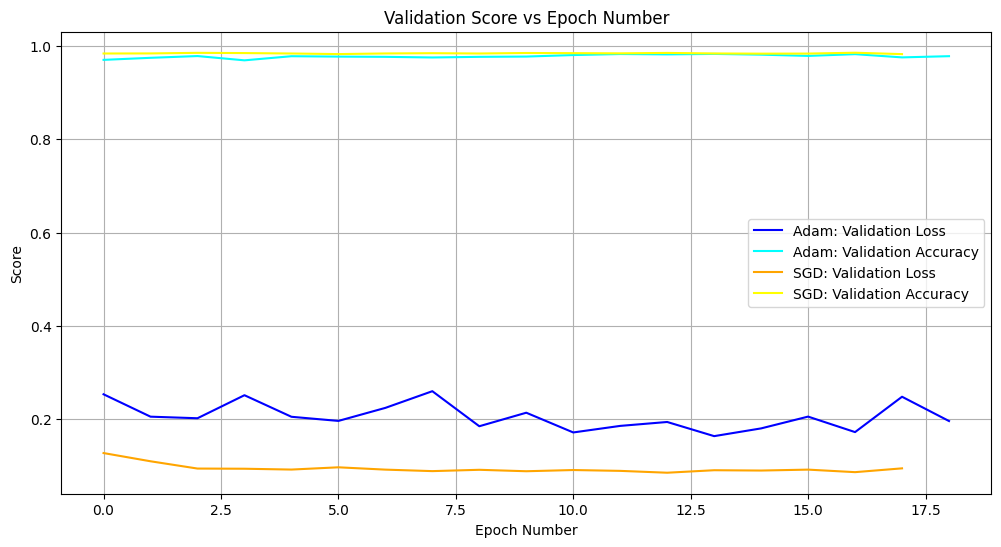

In [7]:

# Create the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement
    restore_best_weights=True  # Restore the best model weights when stopped
)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with Adam optimizer
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Train with Adam for the first 20 epochs or until the early stopping kicks in
    callbacks=[early_stopping]
)

# Change optimizer to SGD and compile the model again
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Continue training with SGD optimizer
history_sgd = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,  # Continue training for another 25 epochs or until the early stopper kicks in
    callbacks=[early_stopping]
)

# Plot validation loss and accuracy for each optimizer
plt.figure(figsize=(12, 6))

# Plot validation loss for Adam
plt.plot(history.history['val_loss'], label='Adam: Validation Loss', color='blue')
# Plot validation accuracy for Adam
plt.plot(history.history['val_accuracy'], label='Adam: Validation Accuracy', color='cyan')

# Plot validation loss for SGD
plt.plot(history_sgd.history['val_loss'], label='SGD: Validation Loss', color='orange')
# Plot validation accuracy for SGD
plt.plot(history_sgd.history['val_accuracy'], label='SGD: Validation Accuracy', color='yellow')

# Add titles and labels
plt.title('Validation Score vs Epoch Number')
plt.xlabel('Epoch Number')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


The below chunk loads and feeds the test data through the model and makes predictions on it based on the training done in the previous step. The data is prepared in a similar manner as before, needing to reshape it to 28x28x1 images and rescaling the pixels.

The predictions are stored in a csv file called "submission_csv" for Kaggle submission and scoring. A score of .97240 was achieved. I was happy with this score and thought it to be impressive for a CNN made from scratch.

In [8]:
# Step 1: Load and preprocess the test data
test_df = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

# Extract the test data (without labels, only pixel data)
X_test = test_df.iloc[:, 1:].values.astype(np.float32)  # pixel data

# Reshape to (num_samples, 28, 28) - 1 channel grayscale images
X_test_reshaped = X_test.reshape(-1, 28, 28)

# Add the channel dimension (1 for grayscale)
X_test_reshaped = np.expand_dims(X_test_reshaped, axis=-1)  # Now shape is (5000, 28, 28, 1)

# Normalize pixel values to the range [0, 1] using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values

# Flow the data through the generator
test_generator = test_datagen.flow(X_test_reshaped, batch_size=1, shuffle=False)

# Step 3: Predict labels for the test data using the trained model
# Use the test generator to make predictions
test_predictions = model.predict(test_generator, verbose=1)

# Convert probabilities to predicted class labels (taking the argmax across the last dimension)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Step 4: Prepare the submission file with 'id' and 'label'
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Assuming 'id' column exists in the test.csv
    'label': test_predicted_labels
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Submission file created successfully!
